### Mega run avec toutes les databases

In [1]:
from torchvision.datasets.folder import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
from statistics import mean
import impaintingLib as imp

import torchvision
from mpl_toolkits.axes_grid1 import ImageGrid
import torch.nn as nn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def plot_img(x,title=""):
    img_grid = make_grid(x[:16])
    plt.figure(figsize=(20,15))
    plt.imshow(img_grid.cpu().permute(1, 2, 0))
    plt.axis('off')
    if title:
        plt.title(title)
    plt.show()
    
def getTestData(file,factorResize=1,doCrop=True):
    resize = (120*factorResize, 120*factorResize)
    crop   = (64*factorResize, 64*factorResize)
    if doCrop :
        process = transforms.Compose([
             transforms.Resize(resize), 
             transforms.CenterCrop(crop),
             transforms.ToTensor()
        ])
    else : 
        process = transforms.Compose([
             transforms.Resize(crop), 
             transforms.ToTensor()
        ])
    return ImageFolder(file, process)

In [2]:
import impaintingLib as imp
classif = imp.loss.getTrainedModel()

def simplifyChannels(x):
    x = np.where(x == 3, 0, x) 
    x = np.where(x == 4, 3, x) 
    x = np.where(x == 5, 3, x) 
    x = np.where(x == 6, 4, x) 
    x = np.where(x == 7, 4, x) 
    x = np.where(x == 8, 5, x) 
    x = np.where(x == 9, 5, x) 
    x = np.where(x == 10 , 6, x) 
    x = np.where(x == 11, 7, x) 
    x = np.where(x == 12, 7, x)  
    x = np.where(x > 12, 0, x)
    return x

def npToTensor(x):
    c,w,h = x.shape
    x = torch.from_numpy(x).to(device)
    x = torch.reshape(x, (c,1,w,h))
    return x.float()

def get_segmentation(x, segmenter=classif, scale_factor=4, simplify=True):
    n,c,w,h = x.shape
    with torch.no_grad():
        if scale_factor > 0 :
            x = torch.nn.functional.interpolate(x, scale_factor=scale_factor)
        x = transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))(x)
        y = classif(x)
        if scale_factor > 0 :
            y = torch.nn.functional.avg_pool2d(y, scale_factor)
            
    y = imp.loss.generate_label_plain(y,w)
    if simplify: 
        y = simplifyChannels(y)
    y =  (y / (np.amax(y)+2)) + 0.1
    y = npToTensor(y)
    return y

In [3]:
keypointModel = imp.model.XceptionNet().to(device) 
keypointModel.load_state_dict(torch.load("./modelSave/keypoint.pt"))
keypointModel.eval()

def visualize_batch(images_list, landmarks_list, shape = (1, 8), title = None, save = None):
    n,c,w,h = images_list.shape
    image_dim = w
    fig = plt.figure(figsize = (20, 15))
    grid = ImageGrid(fig, 111, nrows_ncols = shape, axes_pad = 0.08)
    for ax, image, landmarks in zip(grid, images_list, landmarks_list):
        image = (image - image.min())/(image.max() - image.min())
        landmarks = landmarks.view(-1, 2)
        landmarks = (landmarks + 0.5) * image_dim
        landmarks = landmarks.cpu().detach().numpy().tolist()
        landmarks = np.array([(x, y) for (x, y) in landmarks if 0 <= x <= image_dim and 0 <= y <= image_dim])

        ax.imshow(image[0].cpu(), cmap = 'gray')
        ax.scatter(landmarks[:, 0], landmarks[:, 1], s = 10, c = 'dodgerblue')
        ax.axis('off')

    if title:
        print(title)
    if save:
        plt.savefig(save)
    plt.show()
    
def addKeypoints(images_list, landmarks_list, shape = (1, 8), title = None, save = None):
    n,c,w,h = images_list.shape
    image_dim = w
    layers = torch.zeros((n,1, w, h), dtype=images_list.dtype, device=images_list.device)
    for i,(image, landmarks) in enumerate(zip(images_list, landmarks_list)):
        image = (image - image.min())/(image.max() - image.min())
        landmarks = landmarks.view(-1, 2)
        landmarks = (landmarks + 0.5) * image_dim
        landmarks = landmarks.cpu().detach().numpy().tolist()
        landmarks = np.array([(x, y) for (x, y) in landmarks if 0 <= x <= image_dim and 0 <= y <= image_dim])
        landmarks = torch.from_numpy(landmarks).to(device)
        
        layer = torch.empty((1, w, h), dtype=images_list.dtype, device=images_list.device).fill_(0.1)
        for x,y in landmarks:
            x = int(x.item()) - 1
            y = int(y.item()) - 1
            layer[0][y][x] = 1
        layers[i] = layer
    return layers

def getKeypoints(x, model=keypointModel, shape = (1, 8), title = None, save = None):
    x = torchvision.transforms.Grayscale()(x)
    keypoints = model(x)
    layers = addKeypoints(x, keypoints, shape = shape, title = title, save = save)
    return layers

def keypointLoss(x,x_hat):
    keypointX = getKeypoints(x)
    keypointX_hat = getKeypoints(x_hat)
    mse = torch.nn.MSELoss()
    loss = mse(keypointX,keypointX_hat)
    if not loss :
        loss = 0
    return loss

In [4]:
from torch.utils.tensorboard import SummaryWriter

def train_inpainting_segmented_keypoints(net, optimizer, loader, alter, runName="bigRun", scale_factor=4, epochs=5, simplify_seg=True, show_images=True):
    
    net.train()
    for epoch in range(epochs):
        running_loss = []
        t = tqdm(loader)
        for x, _ in t:
            x = x.to(device)
            segmented = get_segmentation(x, simplify=simplify_seg, scale_factor=scale_factor)
            x_prime = alter(x)
            x_input = torch.cat((x_prime, segmented),dim=1)
            keypointLayer = getKeypoints(x)
            x_input = torch.cat((x_input, keypointLayer),dim=1)
        
            outputs = net(x_input)
            
            loss = 0
            loss += torch.nn.L1Loss()(outputs, x)
            loss += imp.loss.perceptualVGG(outputs, x)
            loss += imp.loss.totalVariation(outputs, x)
            # loss += keypointLoss(outputs,x) * 200
            
            running_loss.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            t.set_description(f'training loss: {mean(running_loss)}, epoch: {epoch}/{epochs}')
            
        if show_images:
            plot_img(x[:8])
            plot_img(x_prime[:8])
            plot_img(segmented[:8])
            plot_img(torch.clip(outputs[:8], 0, 1))
            plot_img(keypointLayer[:8])
            
        writer = SummaryWriter("runs/" + runName)
        writer.add_scalar("training loss", mean(running_loss), epoch)
        writer.add_image("Original",make_grid(x[:8]))
        writer.add_image("Predict",make_grid(torch.clip(outputs[:8], 0, 1)))
        writer.close()
        
        if (epoch % 2) == 0 :
            torch.save(net.state_dict(),"./modelSave/01_09/{}_{}".format(runName,epoch))
        
            
def test_results_sample_keypoints(net, testloader, alter, simplify_seg=True, min_cut=15,max_cut=45, scale_factor=4,title=""):
    
    net.eval()
    with torch.no_grad():
        x, _ = next(iter(testloader))
        x = x.to(device)
        segmented = get_segmentation(x, simplify=simplify_seg, scale_factor=scale_factor)
        x_prime = alter(x)
        x_input = torch.cat((x_prime, segmented),dim=1)
        keypointLayer = getKeypoints(x)
        x_input = torch.cat((x_input, keypointLayer),dim=1)
        
        outputs = net(x_input)
        #plot_img(x[:8])
        #plot_img(x_prime[:8])
        #plot_img(segmented[:8])
        plot_img(torch.clip(outputs[:8], 0, 1),title=title)
        #plot_img(keypointLayer[:8])

In [ ]:
factorResize = 4
scale_factor = 1
batch_size=16
runName = "best256"
model = imp.model.UNet(5, netType="partial").to(device) 
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=0.001)
alter = imp.mask.Alter(resize=factorResize,seed=0,test=True).irregularMask # squareMask irregularMask

datasets = []
datasets.append(getTestData("./data/flickr",factorResize=factorResize,doCrop=False))
#datasets[0], _ = torch.utils.data.random_split(datasets[0], [3000, len(datasets[0])-3000])
datasets.append(getTestData("./data/lfw",factorResize=factorResize))
dataset = torch.utils.data.ConcatDataset(datasets)

#dataset = getTestData("./data/lfw",factorResize=factorResize)
#reste = len(dataset)%batch_size
#dataset, _ = torch.utils.data.random_split(dataset, [len(dataset)-reste, reste])

trainloader = DataLoader(dataset, num_workers=2, batch_size=batch_size, shuffle=True)
model.load_state_dict(torch.load("./modelSave/24_08/bigRun260"))
train_inpainting_segmented_keypoints(model, optimizer, trainloader, alter, runName=runName, scale_factor=scale_factor, simplify_seg=True, epochs=20)
torch.save(model.state_dict(),"./modelSave/09_01/" + runName)

  0%|          | 0/4986 [00:00<?, ?it/s]

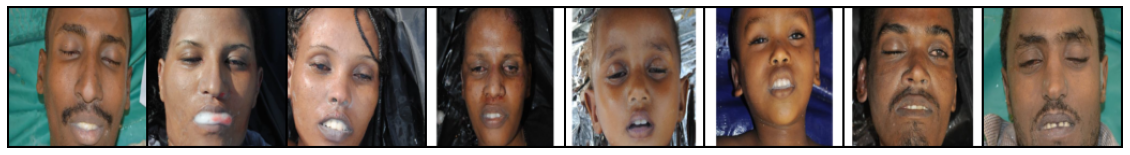

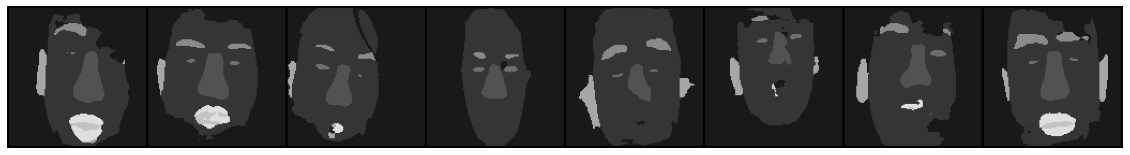

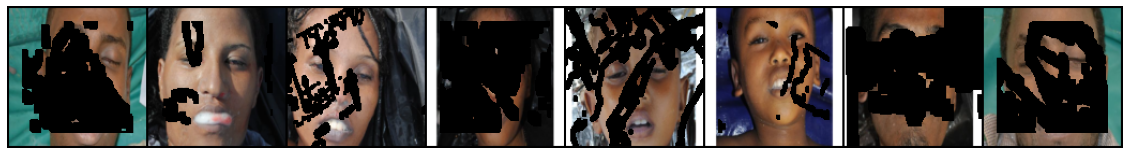

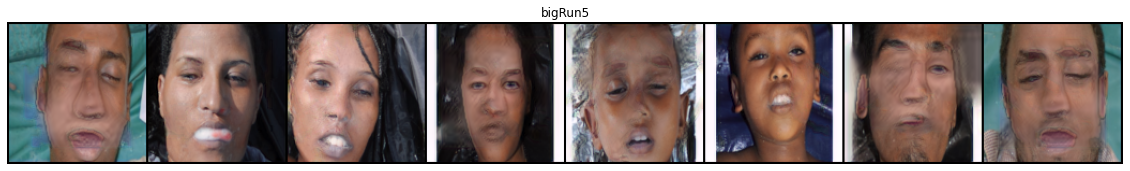

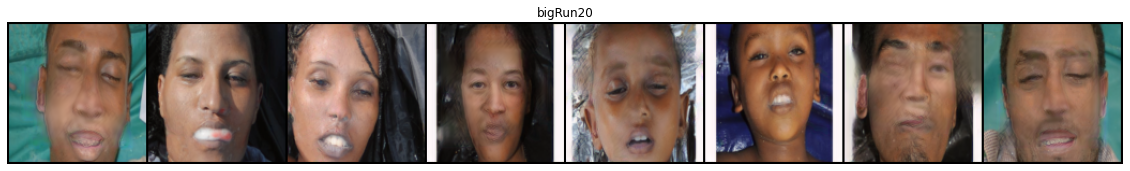

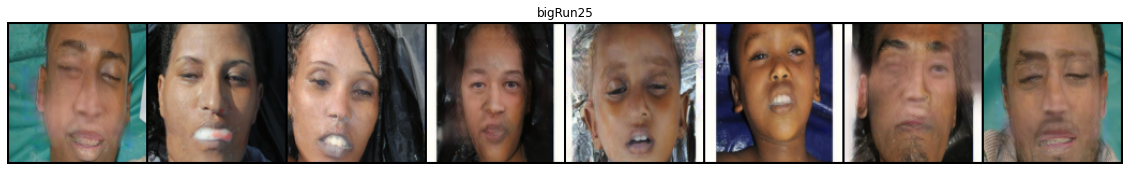

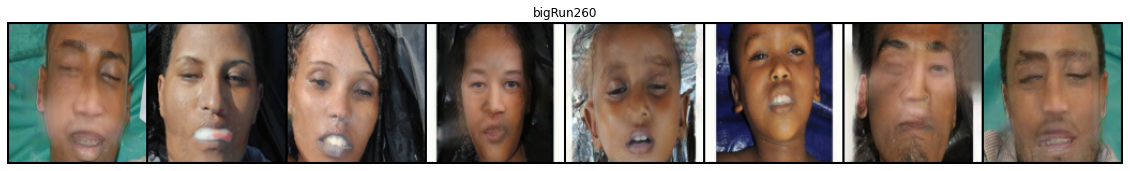

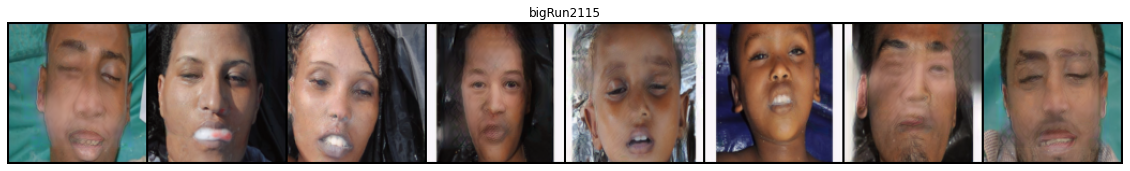

In [9]:
def multipleTests(suffixe):
    model = imp.model.UNet(5, netType="partial").to(device) 
    model.load_state_dict(torch.load("./modelSave/24_08/" + suffixe))
    model.eval()
    with torch.no_grad():
        alter = imp.mask.Alter(resize=factorResize,seed=seed,test=True).irregularMask # squareMask irregularMask
        test_results_sample_keypoints(model, testloader, alter, simplify_seg=True,scale_factor=scale_factor, title=suffixe)
        
factorResize = 2
scale_factor = 2
seed = 4 #1 2 3 4
torch.manual_seed(seed)

dataset = getTestData("./data/real",factorResize=factorResize)
testloader = DataLoader(dataset, num_workers=2, batch_size=16, shuffle=False)

alter = imp.mask.Alter(resize=factorResize,seed=seed,test=True).irregularMask # squareMask irregularMask
x,_ = next(iter(testloader))
x = x.to(device)
segmented = get_segmentation(x, simplify=True, scale_factor=scale_factor)
x_prime = alter(x)
plot_img(x[:8])
plot_img(segmented[:8])
plot_img(x_prime[:8])

toTest = ["bigRun5","bigRun20","bigRun25","bigRun260","bigRun2115"]    
for suffixe in toTest :
    multipleTests(suffixe)

## Gan de deepfill

In [5]:
import torch.nn.functional as F

class Conv2DSpectralNorm(nn.Conv2d):
    """Convolution layer that applies Spectral Normalization before every call."""

    def __init__(self, cnum_in,
                 cnum_out, kernel_size, stride, padding=0, n_iter=1, eps=1e-12, bias=True):
        super().__init__(cnum_in,
                         cnum_out, kernel_size=kernel_size,
                         stride=stride, padding=padding, bias=bias)
        self.register_buffer("weight_u", torch.empty(self.weight.size(0), 1))
        nn.init.trunc_normal_(self.weight_u)
        self.n_iter = n_iter
        self.eps = eps

    def l2_norm(self, x):
        return F.normalize(x, p=2, dim=0, eps=self.eps)

    def forward(self, x):

        weight_orig = self.weight.flatten(1).detach()

        for _ in range(self.n_iter):
            v = self.l2_norm(weight_orig.t() @ self.weight_u)
            self.weight_u = self.l2_norm(weight_orig @ v)

        sigma = self.weight_u.t() @ weight_orig @ v
        self.weight.data.div_(sigma)

        x = super().forward(x)

        return x

# ----------------------------------------------------------------------------

class DConv(nn.Module):
    def __init__(self, cnum_in,
                 cnum_out, ksize=5, stride=2, padding='auto'):
        super().__init__()
        padding = (ksize-1)//2 if padding == 'auto' else padding
        self.conv_sn = Conv2DSpectralNorm(
            cnum_in, cnum_out, ksize, stride, padding)
        #self.conv_sn = spectral_norm(nn.Conv2d(cnum_in, cnum_out, ksize, stride, padding))
        self.leaky = nn.LeakyReLU(negative_slope=0.2)

    def forward(self, x):
        x = self.conv_sn(x)
        x = self.leaky(x)
        return x

# ----------------------------------------------------------------------------

class Discriminator(nn.Module):
    def __init__(self, cnum_in, cnum):
        super().__init__()
        self.conv1 = DConv(cnum_in, cnum)
        self.conv2 = DConv(cnum, 2*cnum)
        self.conv3 = DConv(2*cnum, 4*cnum)
        self.conv4 = DConv(4*cnum, 4*cnum)
        self.conv5 = DConv(4*cnum, 4*cnum)
        self.conv6 = DConv(4*cnum, 4*cnum)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = nn.Flatten()(x)

        return x

In [12]:
def hinge_loss_d(pos, neg):
    """
    gan with hinge loss:
    https://github.com/pfnet-research/sngan_projection/blob/c26cedf7384c9776bcbe5764cb5ca5376e762007/updater.py
    """
    hinge_pos = torch.mean(torch.relu(1-pos))
    hinge_neg = torch.mean(torch.relu(1+neg))
    d_loss = 0.
    d_loss += 0.5*hinge_pos + 0.5*hinge_neg   
    return d_loss

def allButMask(x):
    x_segmented = get_segmentation(x, simplify=True, scale_factor=2)
    x_input = torch.cat((x, x_segmented),dim=1)
    x_keypointLayer = getKeypoints(x)
    x_input = torch.cat((x_input, x_keypointLayer),dim=1)
    return x_input

def successRate(d):
    n,w = d.shape
    d_red = torch.empty((n), dtype=d.dtype, device=d.device)
    for i,img in enumerate(d) :
        d_red[i] = torch.mean(img)
    res = torch.sum(d_red < 0.5) / torch.numel(d_red)
    return res

def ganLoss(x, x_hat, discriminator):
    x_input = allButMask(x)
    x_hat_input = allButMask(x_hat)
    
    batch_real_filled = torch.cat((x_input, x_hat_input))
    d_real_gen = discriminator(batch_real_filled)
    d_real, d_gen = torch.split(d_real_gen, 16)
    d_loss = hinge_loss_d(d_real, d_gen)
    
    sr_real = successRate(torch.relu(1-d_real))
    sr_gen  = successRate(torch.relu(1+d_gen))
          
    return d_loss, sr_gen, sr_real

In [13]:
from torch.utils.tensorboard import SummaryWriter

def train_inpainting_segmented_keypoints_GAN(net, g_optimizer, discriminator, d_optimizer, loader, alter, runName,scale_factor=4, epochs=5, simplify_seg=True, show_images=True):
    
    net.train()
    for epoch in range(epochs):
        running_loss = []
        running_loss_gan = []
        running_sr_gen = []
        running_sr_real = []
        
        t = tqdm(loader)
        for x, _ in t:
            x = x.to(device)
            segmented = get_segmentation(x, simplify=simplify_seg, scale_factor=scale_factor)
            x_prime = alter(x)
            x_input = torch.cat((x_prime, segmented),dim=1)
            keypointLayer = getKeypoints(x)
            x_input = torch.cat((x_input, keypointLayer),dim=1)
        
            outputs = net(x_input)
            
            loss = 0
            loss += torch.nn.L1Loss()(outputs, x)
            loss += imp.loss.perceptualVGG(outputs, x)
            loss += imp.loss.totalVariation(outputs, x)
            
            d_loss, sr_gen, sr_real = ganLoss(x, outputs, discriminator)
            loss += d_loss
            #d_optimizer.zero_grad()
            #d_loss.backward()
            #d_optimizer.step()
            
            running_loss.append(loss.item())
            running_loss_gan.append(d_loss.item())
            running_sr_gen.append(sr_gen.item())
            running_sr_real.append(sr_real.item())
            
            g_optimizer.zero_grad()
            d_optimizer.zero_grad()
            loss.backward()
            g_optimizer.step()
            d_optimizer.step()
            
            t.set_description(f'training loss: {mean(running_loss):.4f}, GAN loss: {mean(running_loss_gan):.4f}, SR Gen : {mean(running_sr_gen):.2f}, SR Real : {mean(running_sr_real):.2f}, epoch: {epoch}/{epochs}')
            
        torch.save(model.state_dict(),f"./modelSave/01_09/{runName}{epoch}")
        if show_images:
            plot_img(x[:8])
            plot_img(x_prime[:8])
            plot_img(segmented[:8])
            plot_img(torch.clip(outputs[:8], 0, 1))
            plot_img(keypointLayer[:8])   
        

  0%|          | 0/1015 [00:00<?, ?it/s]

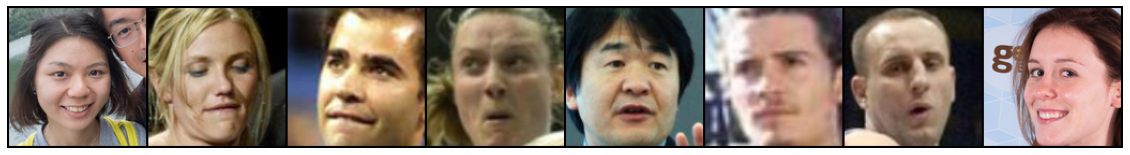

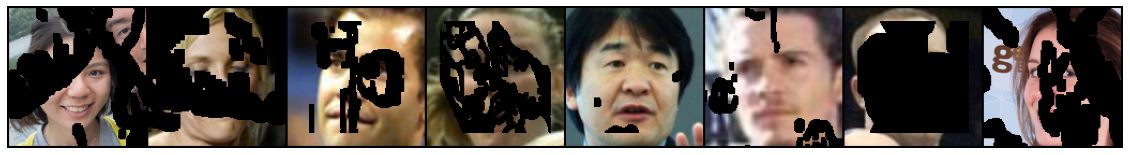

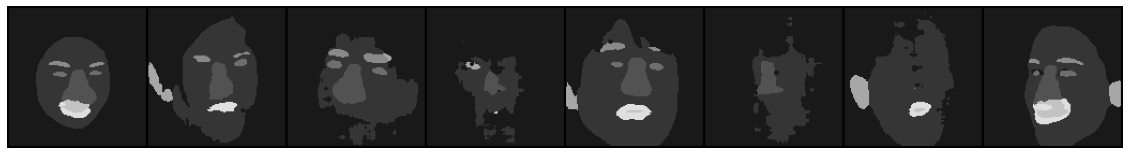

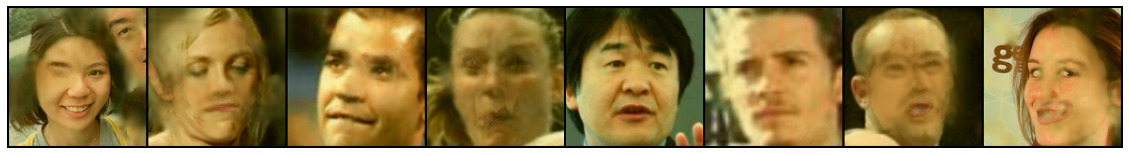

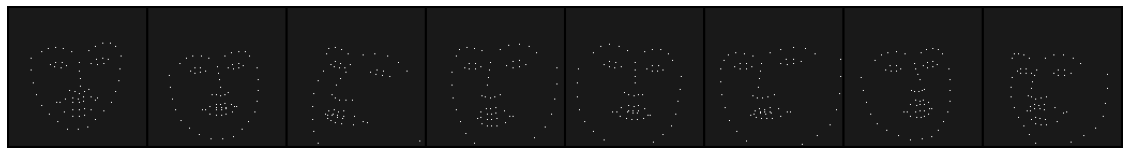

  0%|          | 0/1015 [00:00<?, ?it/s]

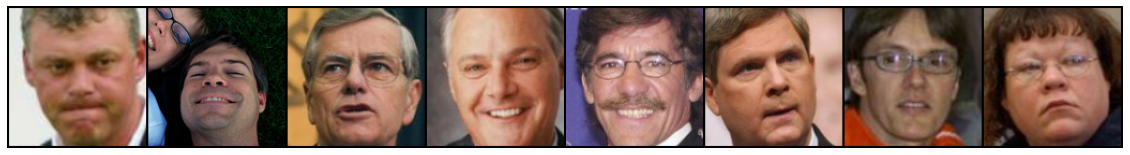

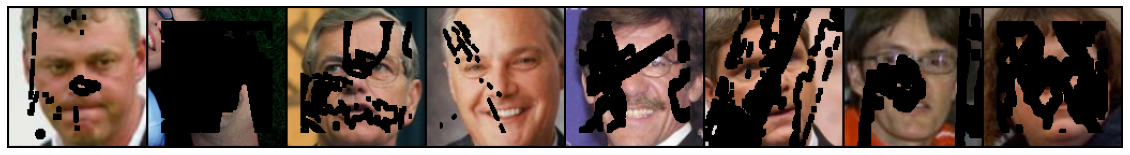

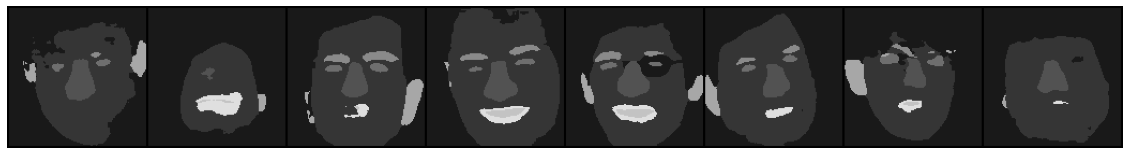

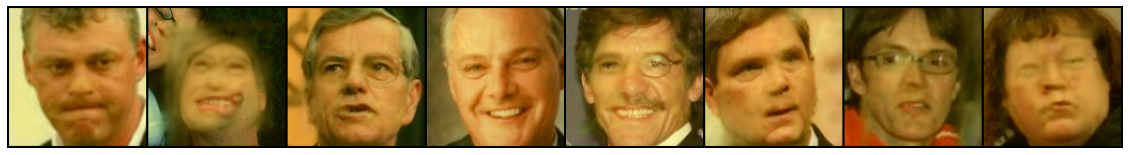

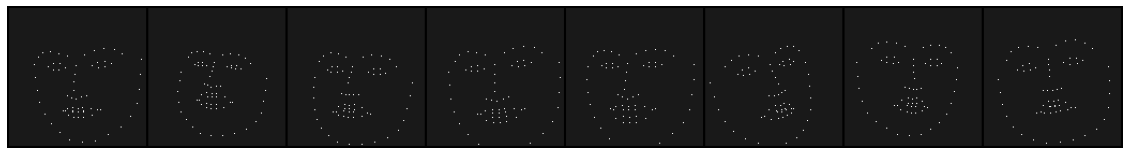

  0%|          | 0/1015 [00:00<?, ?it/s]

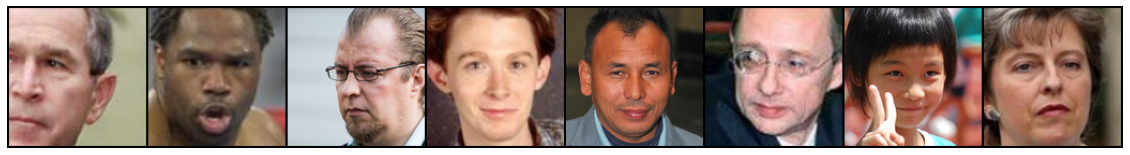

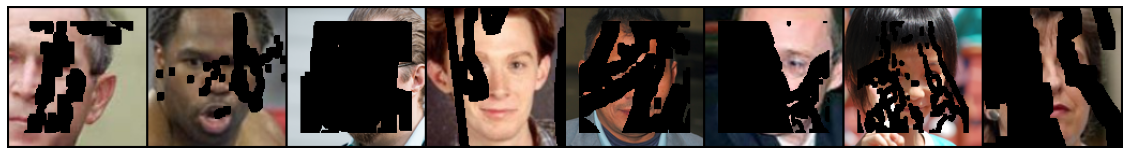

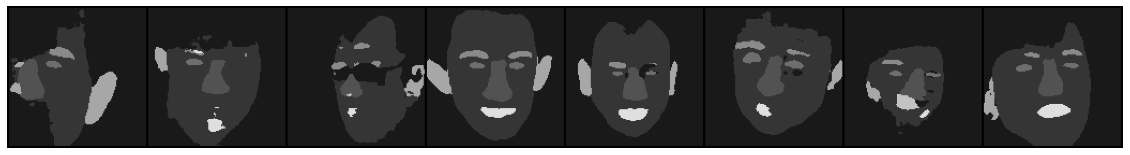

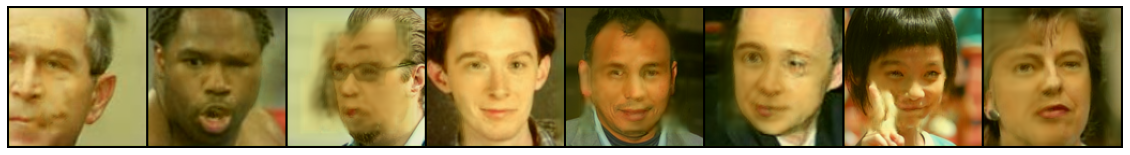

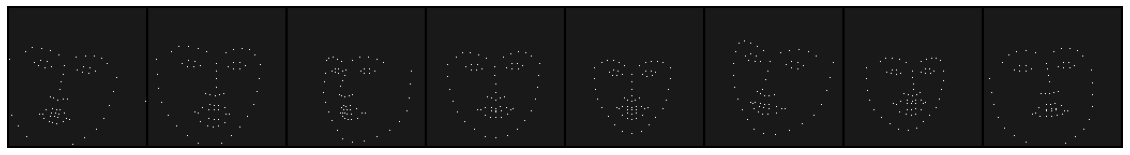

  0%|          | 0/1015 [00:00<?, ?it/s]

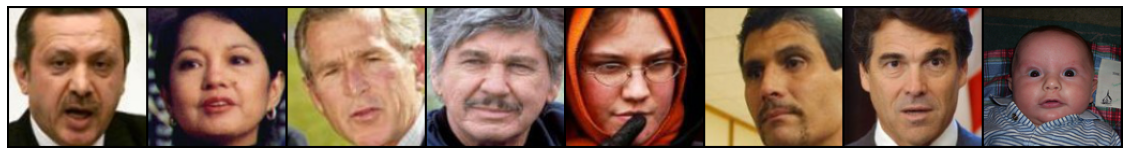

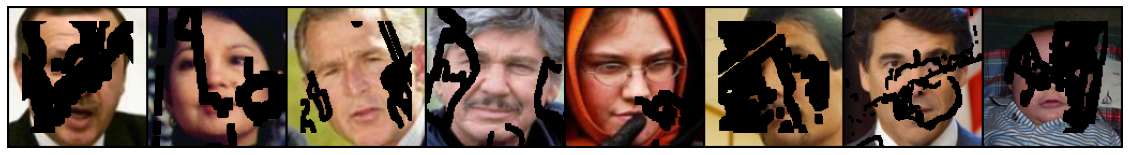

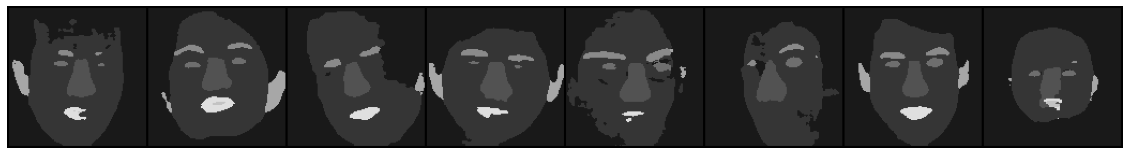

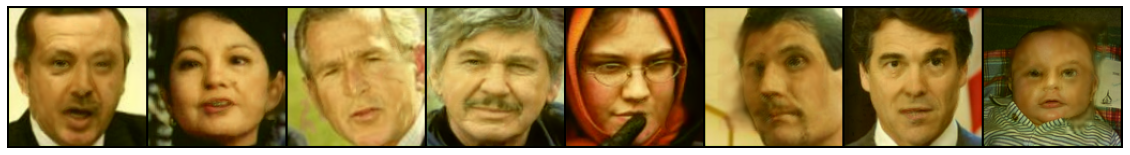

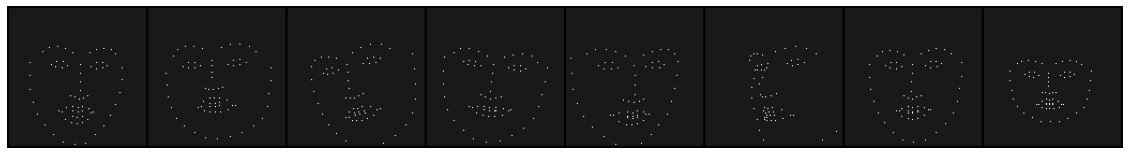

  0%|          | 0/1015 [00:00<?, ?it/s]

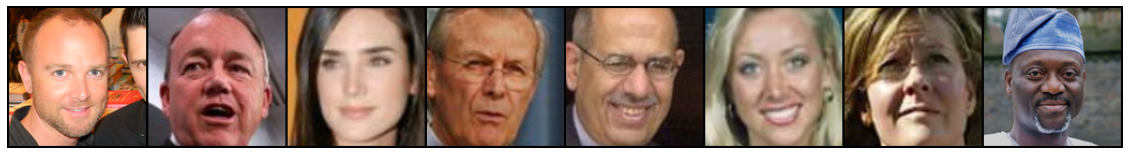

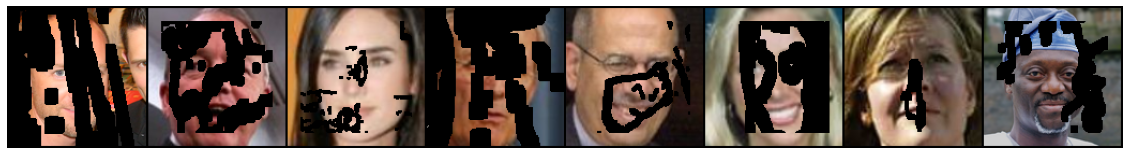

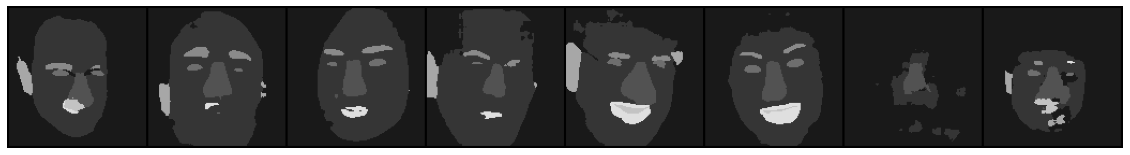

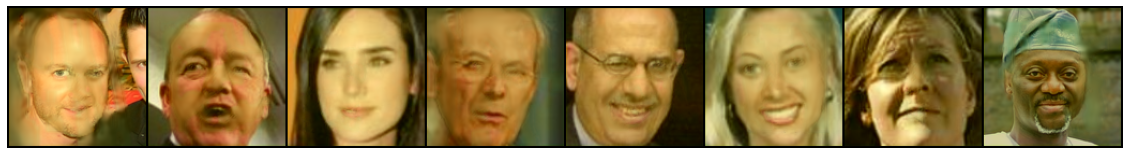

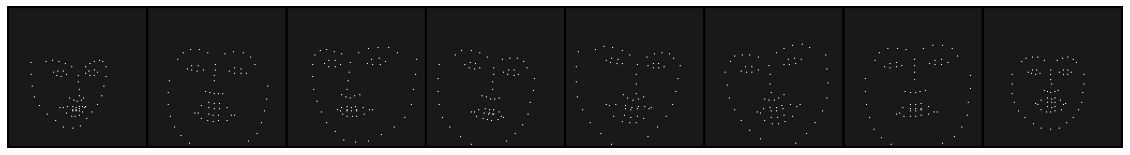

In [14]:
factorResize = 2
scale_factor = 2
batch_size=16
runName = "gan"
model = imp.model.UNet(5, netType="partial").to(device) 
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=0.001)
alter = imp.mask.Alter(resize=factorResize,seed=0,test=True).irregularMask # squareMask irregularMask

discriminator = Discriminator(cnum_in=5, cnum=64)
discriminator = discriminator.to(device)
discriminator.train()
d_optimizer = torch.optim.Adam(
    discriminator.parameters(), lr=0.0001, betas=(0.5,0.999))
    
datasets = []
datasets.append(getTestData("./data/flickr",factorResize=factorResize,doCrop=False))
datasets[0], _ = torch.utils.data.random_split(datasets[0], [3000, len(datasets[0])-3000])
datasets.append(getTestData("./data/lfw",factorResize=factorResize))
dataset = torch.utils.data.ConcatDataset(datasets)
trainloader = DataLoader(dataset, num_workers=2, batch_size=16, shuffle=True)

#dataset = getTestData("./data/lfw",factorResize=factorResize)
#reste = len(dataset)%batch_size
#dataset, _ = torch.utils.data.random_split(dataset, [len(dataset)-reste, reste])
#trainloader = DataLoader(dataset, num_workers=2, batch_size=batch_size, shuffle=True)

#model.load_state_dict(torch.load("./modelSave/24_08/bigRun20"))
train_inpainting_segmented_keypoints_GAN(model, optimizer, discriminator, d_optimizer, trainloader, alter, runName=runName, scale_factor=scale_factor, simplify_seg=True, epochs=5)
torch.save(model.state_dict(),"./modelSave/01_09/" + runName)

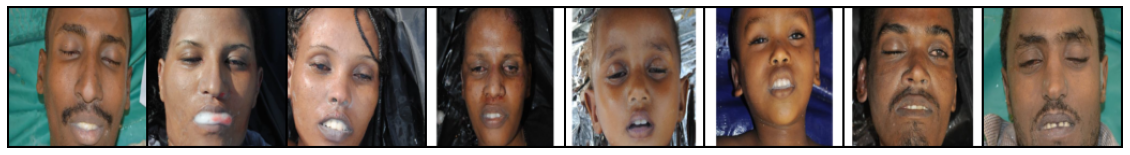

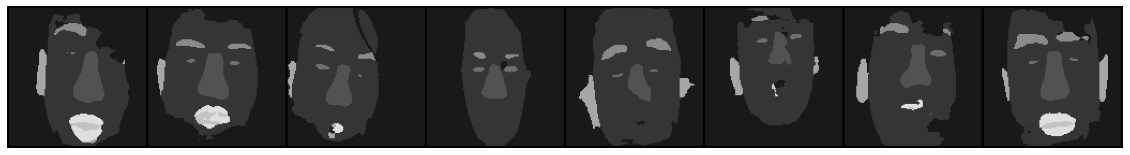

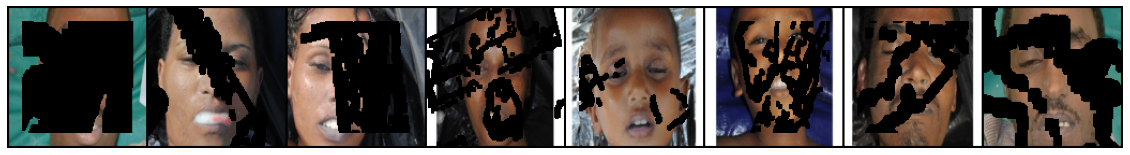

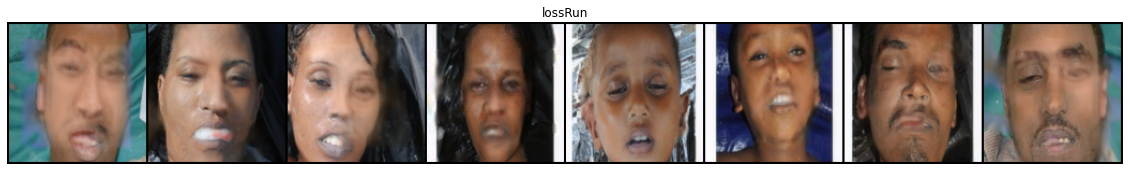

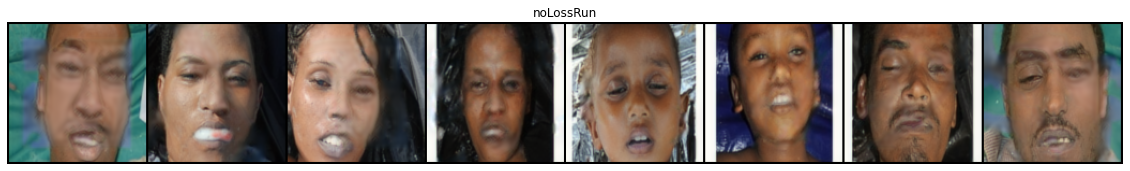

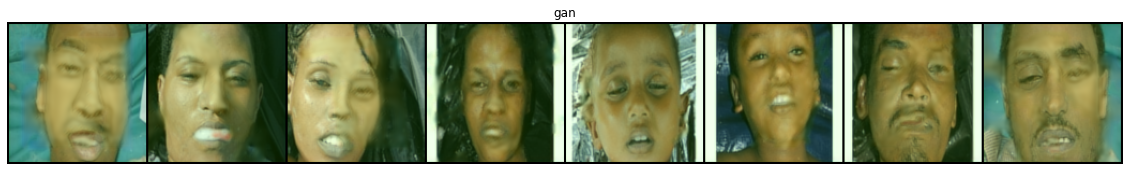

In [12]:
def multipleTests(suffixe):
    model = imp.model.UNet(5, netType="partial").to(device) 
    model.load_state_dict(torch.load("./modelSave/24_08/" + suffixe))
    model.eval()
    with torch.no_grad():
        alter = imp.mask.Alter(resize=factorResize,seed=seed,test=True).irregularMask # squareMask irregularMask
        test_results_sample_keypoints(model, testloader, alter, simplify_seg=True,scale_factor=scale_factor, title=suffixe)
        
factorResize = 2
scale_factor = 2
seed = 3 #1 2 3 4
torch.manual_seed(seed)

dataset = getTestData("./data/real",factorResize=factorResize)
testloader = DataLoader(dataset, num_workers=2, batch_size=16, shuffle=False)

alter = imp.mask.Alter(resize=factorResize,seed=seed,test=True).irregularMask # squareMask irregularMask
x,_ = next(iter(testloader))
x = x.to(device)
segmented = get_segmentation(x, simplify=True, scale_factor=scale_factor)
x_prime = alter(x)
plot_img(x[:8])
plot_img(segmented[:8])
plot_img(x_prime[:8])

toTest = ["lossRun","noLossRun","gan"]    
for suffixe in toTest :
    multipleTests(suffixe)